# Time series analysis

## Read the data and do initial EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (16, 8)

In [2]:
def plot_temp_data(data:pd.DataFrame, titletext="", legend=True) -> None:
    fig=px.line(
    data,
    labels={
        "value": "avg. Temp in °C",
        "variable" : "Graphs:",
    },
    template="plotly_dark"
    )
    
    fig.update_layout(
    title={
        'text': titletext,
        #"font": dict(size=20),
        #'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'bottom'})
    
    if not legend:
        fig.update_layout(showlegend=False)

    fig.show()

In [3]:
df = pd.read_csv(
    "../data/wunstorf.txt",
    skiprows=19,
    index_col=1,
    parse_dates=True,
    )
df.columns

Index([' SOUID', '   TG', ' Q_TG'], dtype='object')

In [4]:
df.rename(
    columns={
        df.columns[0]: "stationID",
        df.columns[1]: "avgTemp",
        df.columns[2]: "qCode"
    },
    inplace=True
    )
df.index.name = "date"

In [5]:
df.sample(10)

stationID  avgTemp  qCode
date                                 
2011-10-16     910334       90      0
1992-09-04     130572    -9999      9
1990-07-28     130572    -9999      9
1997-10-02     910334    -9999      0
1993-11-04     910334    -9999      0
1998-05-13     910334    -9999      0
1995-10-06     910334      134      0
1995-04-12     910334       94      0
1999-05-11     910334    -9999      0
1993-07-08     910334    -9999      0

In [6]:
plot_temp_data(df["avgTemp"]*0.1, "Full Data", False)

## Impute missing values and correct outliers

In [7]:
# Too many missing values before 2003!
strippeddf = df.loc["2003-01-01":]
nandf = strippeddf.replace(-9999, np.nan)
nandf["avgTemp"] = nandf["avgTemp"]*0.1

In [8]:
plot_temp_data(nandf["avgTemp"], "2003 to 2023", False)

In [9]:
nandf.loc["2014-07-25":"2014-07-27","avgTemp"] = np.nan
nandf.loc["2005-11-14","avgTemp"] = np.nan

In [10]:
nandf["avgTemp"].__len__(), nandf["avgTemp"].count()

(7456, 7375)

In [11]:
# source: https://stackoverflow.com/questions/29007830/identifying-consecutive-nans-with-pandas
# returns a pd.series consecutive NaNs, how many there are in a cluster and where they are.
cons_nans = nandf["avgTemp"].isna().astype(int).groupby(nandf["avgTemp"].notna().astype(int).cumsum()).sum()
cons_nans.index = nandf.dropna().index
fig = px.histogram(cons_nans[cons_nans > 0], template='plotly_dark', text_auto=True, labels={
        "value": "# of consecutive NaNs",
    })
fig.update_layout(showlegend=False, bargap=0.2)

In [12]:
fig = px.scatter(
    cons_nans[cons_nans > 0],
    color="value",
    marginal_x="violin",
    template='plotly_dark',
    labels={
        "value": "# of consecutive NaNs",
    }
)

fig.update_layout(showlegend=False)
fig.show()

In [13]:
tdf = nandf["avgTemp"].interpolate(method="time")

In [14]:
tdf.__len__(), tdf.count()

(7456, 7456)

In [15]:
plot_temp_data(tdf, "2003 to 2023 with interpolated outliers", False)

## Timestep and Seasonal Dummies

train test split

In [16]:
tdf_train = tdf.loc[:"2021-12-31"]
tdf_test  = tdf.loc["2022-01-01":]

introduce a timestep

In [17]:
tdf_train = pd.DataFrame(tdf_train)
tdf_train["timestep"] = range(len(tdf_train))

In [18]:
X = tdf_train[["timestep"]]
y = tdf_train["avgTemp"]

In [19]:
from sklearn.linear_model import LinearRegression

fit linear trend

In [20]:
m_trend = LinearRegression()
m_trend.fit(X, y)
tdf_train['trend'] = m_trend.predict(X)
plot_temp_data(tdf_train[['avgTemp', 'trend']])
print(m_trend.feature_names_in_,
m_trend.coef_, m_trend.intercept_)
correction = m_trend.coef_[0]

['timestep'] [0.00016333] 10.257930704119158


In [21]:
tdf_train['wo_trend'] = tdf_train['avgTemp'] - tdf_train['trend']
tdf_train

avgTemp  timestep      trend   wo_trend
date                                               
2003-01-01     -3.5         0  10.257931 -13.757931
2003-01-02      5.8         1  10.258094  -4.458094
2003-01-03      3.8         2  10.258257  -6.458257
2003-01-04     -0.6         3  10.258421 -10.858421
2003-01-05     -5.4         4  10.258584 -15.658584
...             ...       ...        ...        ...
2021-12-27     -5.9      6935  11.390652 -17.290652
2021-12-28      5.4      6936  11.390816  -5.990816
2021-12-29      6.9      6937  11.390979  -4.490979
2021-12-30      6.9      6938  11.391142  -4.491142
2021-12-31     13.4      6939  11.391306   2.008694

[6940 rows x 4 columns]

OHE months

In [22]:
seasonal_dummies = pd.get_dummies(tdf_train.index.month,
                                  prefix = 'month',
                                  drop_first = True,
                                  dtype=int
                                  ).set_index(tdf_train.index)

In [23]:
tdf_train = tdf_train.join(seasonal_dummies)
tdf_train.sample(5)

avgTemp  timestep      trend   wo_trend  month_2  month_3  \
date                                                                    
2003-05-29     19.2       148  10.282104   8.917896        0        0   
2021-11-05      8.3      6883  11.382159  -3.082159        0        0   
2020-03-06      5.8      6274  11.282688  -5.482688        0        1   
2004-01-25      3.1       389  10.321468  -7.221468        0        0   
2005-01-26     -1.8       756  10.381411 -12.181411        0        0   

            month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
date                                                                         
2003-05-29        0        1        0        0        0        0         0   
2021-11-05        0        0        0        0        0        0         0   
2020-03-06        0        0        0        0        0        0         0   
2004-01-25        0        0        0        0        0        0         0   
2005-01-26        0        0        0        0        0        0         0   

            month_11  month_12  
date                            
2003-05-29         0         0  
2021-11-05         1         0  
2020-03-06         0         0  
2004-01-25         0         0  
2005-01-26         0         0

## Model "trend + sesonal"

In [24]:
m_trend_seasonal = LinearRegression()
X = tdf_train.drop(columns=['avgTemp', 'trend', 'wo_trend'])
m_trend_seasonal.fit(X, y)
tdf_train['trend_seasonal'] = m_trend_seasonal.predict(X)

In [25]:
plot_temp_data(tdf_train[["avgTemp", "trend_seasonal"]])

## Remainder

In [26]:
tdf_train['remainder'] = tdf_train['avgTemp'] - tdf_train['trend_seasonal']
tdf_train.sample(5)

avgTemp  timestep      trend   wo_trend  month_2  month_3  \
date                                                                    
2017-08-10     16.9      5335  11.129318   5.770682        0        0   
2006-09-22     20.7      1360  10.480065  10.219935        0        0   
2019-06-03     23.2      5997  11.237445  11.962555        0        0   
2007-04-19     10.3      1569  10.514202  -0.214202        0        0   
2017-07-14     16.7      5308  11.124908   5.575092        0        0   

            month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
date                                                                         
2017-08-10        0        0        0        0        1        0         0   
2006-09-22        0        0        0        0        0        1         0   
2019-06-03        0        0        1        0        0        0         0   
2007-04-19        1        0        0        0        0        0         0   
2017-07-14        0        0        0        1        0        0         0   

            month_11  month_12  trend_seasonal  remainder  
date                                                       
2017-08-10         0         0       19.419607  -2.519607  
2006-09-22         0         0       15.422977   5.277023  
2019-06-03         0         0       18.197273   5.002727  
2007-04-19         0         0       10.162051   0.137949  
2017-07-14         0         0       19.975702  -3.275702

In [27]:
plot_temp_data(tdf_train["remainder"], "Remainder", False)

have a look at partial autocorrelation of remainder and lags

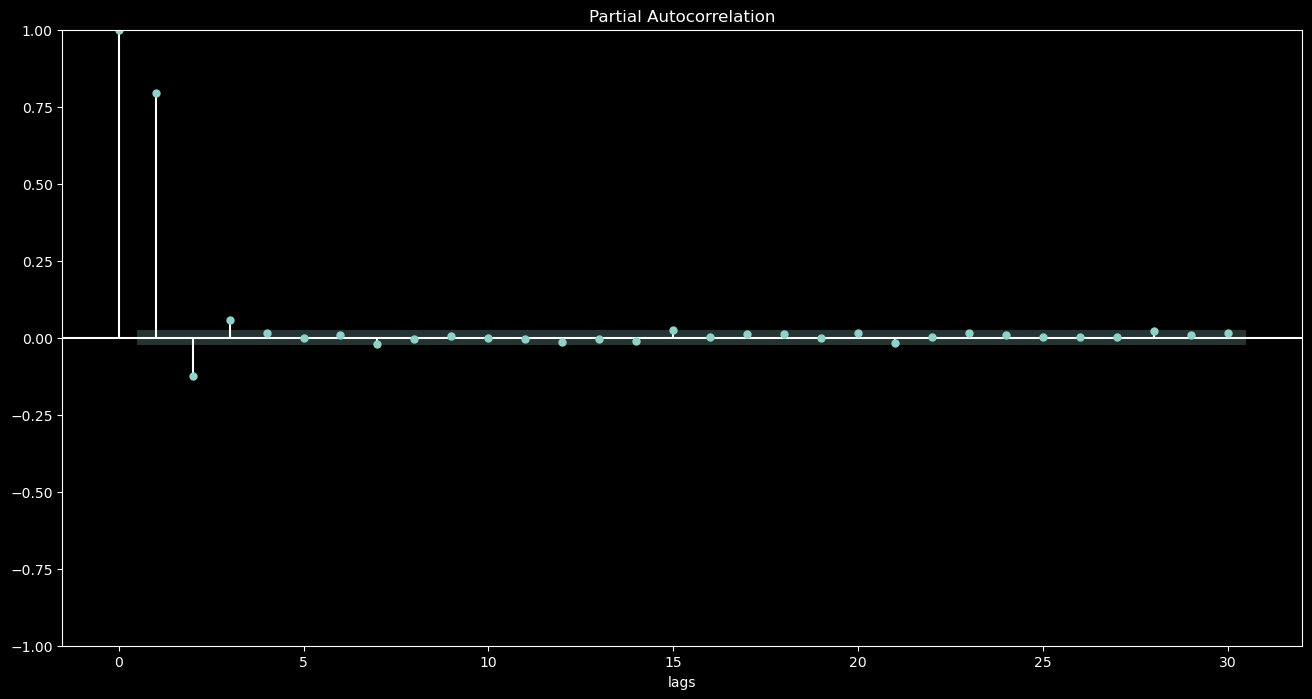

In [28]:
# find which lags we need

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(tdf_train['remainder'], lags=30)
plt.xlabel('lags');

In [29]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

ar_select_order(tdf_train['remainder'], maxlag = 30).ar_lags

/home/david/.miniforge3/envs/davenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



/home/david/.miniforge3/envs/davenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



[1, 2, 3]

introducing lags 1,2,3

In [30]:
tdf_train['lag1'] = tdf_train['remainder'].shift(1)
tdf_train['lag2'] = tdf_train['remainder'].shift(2)
tdf_train['lag3'] = tdf_train['remainder'].shift(3)

tdf_train.head(5)

avgTemp  timestep      trend   wo_trend  month_2  month_3  \
date                                                                    
2003-01-01     -3.5         0  10.257931 -13.757931        0        0   
2003-01-02      5.8         1  10.258094  -4.458094        0        0   
2003-01-03      3.8         2  10.258257  -6.458257        0        0   
2003-01-04     -0.6         3  10.258421 -10.858421        0        0   
2003-01-05     -5.4         4  10.258584 -15.658584        0        0   

            month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
date                                                                         
2003-01-01        0        0        0        0        0        0         0   
2003-01-02        0        0        0        0        0        0         0   
2003-01-03        0        0        0        0        0        0         0   
2003-01-04        0        0        0        0        0        0         0   
2003-01-05        0        0        0        0        0        0         0   

            month_11  month_12  trend_seasonal  remainder      lag1      lag2  \
date                                                                            
2003-01-01         0         0        1.847919  -5.347919       NaN       NaN   
2003-01-02         0         0        1.848042   3.951958 -5.347919       NaN   
2003-01-03         0         0        1.848166   1.951834  3.951958 -5.347919   
2003-01-04         0         0        1.848289  -2.448289  1.951834  3.951958   
2003-01-05         0         0        1.848412  -7.248412 -2.448289  1.951834   

                lag3  
date                  
2003-01-01       NaN  
2003-01-02       NaN  
2003-01-03       NaN  
2003-01-04 -5.347919  
2003-01-05  3.951958

nan replacements introduced by lag feature

In [31]:
Jan_first_mean = (tdf_train.loc[(tdf_train.index.month == 1) & (tdf_train.index.day == 1)]["avgTemp"] - tdf_train["timestep"]*correction).mean()
Jan_sec_mean   = (tdf_train.loc[(tdf_train.index.month == 1) & (tdf_train.index.day == 2)]["avgTemp"] - tdf_train["timestep"]*correction).mean()
Jan_thrd_mean  = (tdf_train.loc[(tdf_train.index.month == 1) & (tdf_train.index.day == 3)]["avgTemp"] - tdf_train["timestep"]*correction).mean()

In [32]:
tdf_train.loc["2003-01-01",["lag1","lag2","lag3"]] = Jan_first_mean
tdf_train.loc["2003-01-02",["lag2","lag3"]]        = Jan_sec_mean
tdf_train.loc["2003-01-03","lag3"]                 = Jan_thrd_mean

In [33]:
tdf_train.loc["2003-01-01":"2003-01-03",["lag1","lag2","lag3"]]

lag1      lag2      lag3
date                                    
2003-01-01  2.342885  2.342885  2.342885
2003-01-02 -5.347919  2.478687  2.478687
2003-01-03  3.951958 -5.347919  1.878524

create the full model also using lag 1,2,3

In [34]:
m_full = LinearRegression()
X = tdf_train.drop(columns=['avgTemp', 'trend', 'wo_trend', 'trend_seasonal', 'remainder'])
m_full.fit(X, y)
tdf_train['full_pred'] = m_full.predict(X)

In [35]:
tdf_train[["avgTemp","full_pred"]]

avgTemp  full_pred
date                          
2003-01-01     -3.5   3.660091
2003-01-02      5.8  -3.297121
2003-01-03      3.8   6.454352
2003-01-04     -0.6   2.573355
2003-01-05     -5.4  -0.500235
...             ...        ...
2021-12-27     -5.9  -4.868251
2021-12-28      5.4  -3.017194
2021-12-29      6.9   6.575732
2021-12-30      6.9   5.918319
2021-12-31     13.4   6.309304

[6940 rows x 2 columns]

In [36]:
plot_temp_data(tdf_train[["avgTemp","full_pred"]], "Full trainingdata prediction")

validate the full model

In [37]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
ts_split = TimeSeriesSplit(n_splits=5)
time_series_split = ts_split.split(X, y)

In [38]:
result = cross_val_score(estimator=m_full, 
                         X=X, y=y,
                         cv=time_series_split)
result

array([0.89811628, 0.9052545 , 0.90615754, 0.90299212, 0.89035869])

In [39]:
result.mean(), result.std()

(0.9005758250028604, 0.005819334471577456)

## Apply model to the test data

add timestep an month OHEs

In [40]:
tdf_test = pd.DataFrame(tdf_test)
tdf_test["timestep"] = range(tdf_train["timestep"].max()+1,tdf_train["timestep"].max()+len(tdf_test)+1)
#tdf_test

In [41]:
seasonal_dummies = pd.get_dummies(tdf_test.index.month,
                                  prefix = 'month',
                                  drop_first = True,
                                  dtype=int
                                  ).set_index(tdf_test.index)
tdf_test = tdf_test.join(seasonal_dummies)
#tdf_test.sample(5)

calculate trend + seasonal for test data

In [42]:
X_test = tdf_test.drop(columns=["avgTemp"])
tdf_test["trend_seasonal"] = m_trend_seasonal.predict(X_test)

In [43]:
plot_temp_data(tdf_test[["avgTemp","trend_seasonal"]], "Testdata")

calculate remainder for test data

In [44]:
tdf_test["remainder"] = tdf_test["avgTemp"] - tdf_test["trend_seasonal"]

create lags

In [45]:
tdf_test["lag1"] = tdf_test["remainder"].shift(1)
tdf_test["lag2"] = tdf_test["remainder"].shift(2)
tdf_test["lag3"] = tdf_test["remainder"].shift(3)

In [46]:
tdf_test.head(5)

avgTemp  timestep  month_2  month_3  month_4  month_5  month_6  \
date                                                                         
2022-01-01     13.5      6940        0        0        0        0        0   
2022-01-02     12.1      6941        0        0        0        0        0   
2022-01-03      9.5      6942        0        0        0        0        0   
2022-01-04      6.9      6943        0        0        0        0        0   
2022-01-05      3.8      6944        0        0        0        0        0   

            month_7  month_8  month_9  month_10  month_11  month_12  \
date                                                                  
2022-01-01        0        0        0         0         0         0   
2022-01-02        0        0        0         0         0         0   
2022-01-03        0        0        0         0         0         0   
2022-01-04        0        0        0         0         0         0   
2022-01-05        0        0        0         0         0         0   

            trend_seasonal  remainder       lag1       lag2       lag3  
date                                                                    
2022-01-01        2.702951  10.797049        NaN        NaN        NaN  
2022-01-02        2.703074   9.396926  10.797049        NaN        NaN  
2022-01-03        2.703197   6.796803   9.396926  10.797049        NaN  
2022-01-04        2.703320   4.196680   6.796803   9.396926  10.797049  
2022-01-05        2.703443   1.096557   4.196680   6.796803   9.396926

fill nans in lag 1,2,3

In [47]:
tdf_test.loc["2022-01-01","lag1"] = tdf_train.loc["2021-12-31","remainder"]

tdf_test.loc["2022-01-01":"2022-01-02","lag2"] = tdf_train.loc["2021-12-30":"2021-12-31","remainder"].values

tdf_test.loc["2022-01-01":"2022-01-03","lag3"] = tdf_train.loc["2021-12-29":"2021-12-31","remainder"].values

In [48]:
tdf_test.head(5)

avgTemp  timestep  month_2  month_3  month_4  month_5  month_6  \
date                                                                         
2022-01-01     13.5      6940        0        0        0        0        0   
2022-01-02     12.1      6941        0        0        0        0        0   
2022-01-03      9.5      6942        0        0        0        0        0   
2022-01-04      6.9      6943        0        0        0        0        0   
2022-01-05      3.8      6944        0        0        0        0        0   

            month_7  month_8  month_9  month_10  month_11  month_12  \
date                                                                  
2022-01-01        0        0        0         0         0         0   
2022-01-02        0        0        0         0         0         0   
2022-01-03        0        0        0         0         0         0   
2022-01-04        0        0        0         0         0         0   
2022-01-05        0        0        0         0         0         0   

            trend_seasonal  remainder       lag1       lag2       lag3  
date                                                                    
2022-01-01        2.702951  10.797049   9.188242   2.688365   2.688488  
2022-01-02        2.703074   9.396926  10.797049   9.188242   2.688365  
2022-01-03        2.703197   6.796803   9.396926  10.797049   9.188242  
2022-01-04        2.703320   4.196680   6.796803   9.396926  10.797049  
2022-01-05        2.703443   1.096557   4.196680   6.796803   9.396926

calculate full predicitons for test data

In [49]:
X_test_full = tdf_test.drop(columns=["avgTemp","trend_seasonal","remainder"])
tdf_test["full_pred"] = m_full.predict(X_test_full)

In [50]:
plot_temp_data(tdf_test[["avgTemp","trend_seasonal","full_pred"]], "Testdata")

combine train and test data

In [51]:
tdf_comb = pd.concat([tdf_train.drop(columns=["trend","wo_trend"]),tdf_test])
tdf_comb.tail()

avgTemp  timestep  month_2  month_3  month_4  month_5  month_6  \
date                                                                         
2023-05-27     14.2      7451        0        0        0        1        0   
2023-05-28     16.9      7452        0        0        0        1        0   
2023-05-29     14.3      7453        0        0        0        1        0   
2023-05-30     12.8      7454        0        0        0        1        0   
2023-05-31     16.7      7455        0        0        0        1        0   

            month_7  month_8  month_9  month_10  month_11  month_12  \
date                                                                  
2023-05-27        0        0        0         0         0         0   
2023-05-28        0        0        0         0         0         0   
2023-05-29        0        0        0         0         0         0   
2023-05-30        0        0        0         0         0         0   
2023-05-31        0        0        0         0         0         0   

            trend_seasonal  remainder      lag1      lag2      lag3  full_pred  
date                                                                            
2023-05-27       14.591470  -0.391470 -2.491347 -2.691223 -3.791100  12.626393  
2023-05-28       14.591593   2.308407 -0.391470 -2.491347 -2.691223  14.550154  
2023-05-29       14.591716  -0.291716  2.308407 -0.391470 -2.491347  16.624854  
2023-05-30       14.591840  -1.791840 -0.291716  2.308407 -0.391470  13.920055  
2023-05-31       14.591963   2.108037 -1.791840 -0.291716  2.308407  13.186272

## train model on combined data

In [52]:
X_comb = tdf_comb.drop(columns=['avgTemp', 'trend_seasonal', 'remainder', 'full_pred'])
y_comb = tdf_comb["avgTemp"]

In [53]:
m_comb = LinearRegression()
m_comb.fit(X_comb, y_comb)
m_comb.coef_

array([ 1.25759073e-04,  5.72024680e-01,  3.61711230e+00,  8.04079634e+00,
        1.18338426e+01,  1.55677741e+01,  1.74313039e+01,  1.68907812e+01,
        1.33554869e+01,  8.75144802e+00,  4.40493384e+00,  1.56602859e+00,
        9.08653650e-01, -1.88647303e-01,  6.24001161e-02])

coefficient sanity check

In [54]:
m_full.coef_

array([ 1.24271172e-04,  5.69938986e-01,  3.64716302e+00,  8.11712063e+00,
        1.18644859e+01,  1.55791491e+01,  1.74725945e+01,  1.69004471e+01,
        1.34056449e+01,  8.74964523e+00,  4.43485173e+00,  1.60381303e+00,
        9.02515832e-01, -1.77983570e-01,  5.82241272e-02])

In [55]:
plot_temp_data(tdf_comb[["avgTemp","trend_seasonal", "full_pred"]], "It's the last plot. I promise :p | (Train+Test)")

## create a future timestep and make a predicition

In [56]:
# 2023-06-01
timestep = tdf_comb["timestep"].max()+1
months = [0]*4+[1]+[0]*6
lag1 = tdf_comb.loc["2023-05-31","remainder"]
lag2 = tdf_comb.loc["2023-05-31","lag1"]
lag3 = tdf_comb.loc["2023-05-31","lag2"]

X_future = [timestep]+months+[lag1,lag2,lag3]

In [57]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_comb.columns
X_future

timestep  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
0      7456        0        0        0        0        1        0        0   

   month_9  month_10  month_11  month_12      lag1     lag2      lag3  
0        0         0         0         0  2.108037 -1.79184 -0.291716

In [58]:
m_comb.predict(X_future)

array([20.58958056])

## test the remainder for stationarity using the augmented dickey-fuller unit root test

In [59]:
from statsmodels.tsa.stattools import adfuller

In [60]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = adfuller(data)
    
    print(f"""
adf:            {round(adf_stats,2)}
p:               {p} 
used lag:        {used_lag} 
# obs:           {n_obs}
p=0.01; CI=99%: {round(levels['1%'],2)}  
p=0.05; CI=95%: {round(levels['5%'],2)}
p=0.1;  CI=90%: {round(levels['10%'],2)}
AIC:             {information_criterion}
""")

In [61]:
print_adf(tdf_comb["remainder"])


adf:            -26.0
p:               0.0 
used lag:        3 
# obs:           7452
p=0.01; CI=99%: -3.43  
p=0.05; CI=95%: -2.86
p=0.1;  CI=90%: -2.57
AIC:             33005.65700339425



## compare autoregressive models using different numbers of lags

In [62]:
from statsmodels.tsa.ar_model import AutoReg

In [63]:
ar_model_1 = AutoReg(endog=tdf_comb['remainder'], lags=1).fit()
ar_model_2 = AutoReg(endog=tdf_comb['remainder'], lags=2).fit()
ar_model_3 = AutoReg(endog=tdf_comb['remainder'], lags=3).fit()
ar_model_4 = AutoReg(endog=tdf_comb['remainder'], lags=4).fit()

/home/david/.miniforge3/envs/davenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/david/.miniforge3/envs/davenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/david/.miniforge3/envs/davenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/david/.miniforge3/envs/davenv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [64]:
ar_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                 7456
Model:                     AutoReg(1)   Log Likelihood              -16676.205
Method:               Conditional MLE   S.D. of innovations              2.266
Date:                Fri, 23 Jun 2023   AIC                          33358.411
Time:                        16:05:53   BIC                          33379.161
Sample:                    01-02-2003   HQIC                         33365.538
                         - 05-31-2023                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0041      0.026      0.155      0.877      -0.047       0.056
remainder.L1     0.7953      0.007    113.296      0.000       0.782       0.809
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2574           +0.0000j            1.2574            0.0000
-----------------------------------------------------------------------------
"""

In [65]:
ar_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                 7456
Model:                     AutoReg(2)   Log Likelihood              -16600.049
Method:               Conditional MLE   S.D. of innovations              2.244
Date:                Fri, 23 Jun 2023   AIC                          33208.098
Time:                        16:05:53   BIC                          33235.764
Sample:                    01-03-2003   HQIC                         33217.601
                         - 05-31-2023                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0033      0.026      0.128      0.898      -0.048       0.054
remainder.L1     0.9025      0.011     78.684      0.000       0.880       0.925
remainder.L2    -0.1342      0.011    -11.703      0.000      -0.157      -0.112
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3993           +0.0000j            1.3993            0.0000
AR.2            5.3248           +0.0000j            5.3248            0.0000
-----------------------------------------------------------------------------
"""

In [66]:
ar_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                 7456
Model:                     AutoReg(3)   Log Likelihood              -16582.985
Method:               Conditional MLE   S.D. of innovations              2.239
Date:                Fri, 23 Jun 2023   AIC                          33175.969
Time:                        16:05:53   BIC                          33210.551
Sample:                    01-04-2003   HQIC                         33187.848
                         - 05-31-2023                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0035      0.026      0.134      0.894      -0.047       0.054
remainder.L1     0.9114      0.012     78.832      0.000       0.889       0.934
remainder.L2    -0.1915      0.015    -12.363      0.000      -0.222      -0.161
remainder.L3     0.0629      0.012      5.445      0.000       0.040       0.086
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3008           -0.0000j            1.3008           -0.0000
AR.2            0.8721           -3.3857j            3.4962           -0.2099
AR.3            0.8721           +3.3857j            3.4962            0.2099
-----------------------------------------------------------------------------
"""

In [67]:
ar_model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                 7456
Model:                     AutoReg(4)   Log Likelihood              -16578.869
Method:               Conditional MLE   S.D. of innovations              2.239
Date:                Fri, 23 Jun 2023   AIC                          33169.738
Time:                        16:05:53   BIC                          33211.235
Sample:                    01-05-2003   HQIC                         33183.992
                         - 05-31-2023                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0038      0.026      0.148      0.882      -0.047       0.055
remainder.L1     0.9100      0.012     78.569      0.000       0.887       0.933
remainder.L2    -0.1869      0.016    -11.941      0.000      -0.218      -0.156
remainder.L3     0.0445      0.016      2.843      0.004       0.014       0.075
remainder.L4     0.0194      0.012      1.677      0.093      -0.003       0.042
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2752           -0.0000j            1.2752           -0.0000
AR.2            1.0672           -2.4388j            2.6620           -0.1843
AR.3            1.0672           +2.4388j            2.6620            0.1843
AR.4           -5.7014           -0.0000j            5.7014           -0.5000
-----------------------------------------------------------------------------
"""

try auto_arima to find best hyperparams for arima models

In [68]:
#from pmdarima import auto_arima

In [69]:
%%script echo skip

m_aarima = auto_arima(
    tdf_comb["avgTemp"],
    start_p=1,
    start_q=1,
    max_p=3, max_q=3, m=12,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion='bic',
    test='adf'
    )

skip
